<div style="max-width:1200px"><img src="../_resources/mgnify_banner.png" width="100%"></div>

<img src="../_resources/mgnify_logo.png" width="200px">

# Pathways Visualization

In this notebook we aim to demonstrate how the MGnifyR tool can be used to fetch functional annotation results generated through the MGnify metagenomic analyisis pipelines. Then we show how to generate the pathways visualization using [Pathview](https://bioconductor.org/packages/release/bioc/html/pathview.html) in R.

[MGnifyR](http://github.com/beadyallen/mgnifyr) is a library that provides a set of tools for easily accessing and processing MGnify data in R, making queries to MGnify databases through the [MGnify API](https://www.ebi.ac.uk/metagenomics/api/v1/). 
The benefit of MGnifyR is that data can either be fetched in tsv format or be directly combined in a phyloseq object to run an analysis in a custom workflow.

This is an interactive code notebook (a Jupyter Notebook). To run this code, click into each cell and press the ▶ button in the top toolbar, or press shift+enter


## Contents

- [Drawing presence/absence KOs for one metagenomic sample](#part1)
    - [1.1. Fetching data from MGnify](#part1_1)
    - [1.2. Selecting the most complete pathways](#part1_2)
    - [1.3. Ready to draw!](#part1_3)
- [Resources and Documentation](#part2)

### Libraries Used
-   **ALDEx2** : Analyzing and comparing the abundance or occurrence of KEGG orthologs or modules within different samples or datasets.
-   **data.table**, **dplyr** : Used for data manipulation and transformation.
-   **KEGGREST** : Allows accessing KEGG pathways.
-   **MGnifyR** : It wraps the MGnify API in R functions.
-   **pathview** : Used for visualizing and analyzing pathway data with gene or protein expression data overlaid.
-   **variable_utils.r** : Contains fucntion to retrieve variables from the environment & user input.
-   **kegg_pathways_utils.r** : Contains functions to fetch and process KEGG pathways.

In [1]:
# Loading libraries:
suppressMessages({
    library(ALDEx2)
    library(data.table)
    library(dplyr)
    library(IRdisplay)
    library(KEGGREST)
    library(MGnifyR)   
    library(pathview)
    library(tidyjson)
    library(IRdisplay)
})
source("lib/variable_utils.r")
source("lib/kegg_pathways_utils.r")

display_markdown(file = '../_resources/mgnifyr_help.md')

Warning message:
“package ‘MASS’ was built under R version 4.2.3”


Warning message:
“package ‘truncnorm’ was built under R version 4.2.3”


Warning message:
“package ‘dplyr’ was built under R version 4.2.3”


# Help with MGnifyR

MGnifyR is an R package that provides a convenient way for R users to access data from [the MGnify API](https://www.ebi.ac.uk/metagenomics/api/).

Detailed help for each function is available in R using the standard `?function_name` command (i.e. typing `?mgnify_query` will bring up built-in help for the mgnify_query command). 

A vignette is available containing a reasonably verbose overview of the main functionality. 
This can be read either within R with the `vignette("MGnifyR")` command, or [in the development repository](https://htmlpreview.github.io/?https://github.com/beadyallen/MGnifyR/blob/master/doc/MGnifyR.html)

## MGnifyR Command cheat sheet

The following list of key functions should give a starting point for finding relevent documentation.

- `mgnify_client()` : Create the client object required for all other functions.
- `mgnify_query()` : Search the whole MGnify database.
- `mgnify_analyses_from_xxx()` : Convert xxx accessions to analyses accessions. xxx is either samples or studies.
- `mgnify_get_analyses_metadata()` : Retrieve all study, sample and analysis metadata for given analyses.
- `mgnify_get_analyses_phyloseq()` : Convert abundance, taxonomic, and sample metadata into a single phyloseq object.
- `mgnify_get_analyses_results()` : Get functional annotation results for a set of analyses.
- `mgnify_download()` : Download raw results files from MGnify.
- `mgnify_retrieve_json()` : Low level API access helper function.


In [2]:
# Create your session mgnify_client object
mg = mgnify_client(usecache = T, cache_dir = '/home/jovyan/.mgnify_cache')

In [3]:
# Setting tables and figures size to display (these will be reset later):
options(repr.matrix.max.cols=150, repr.matrix.max.rows=500)
options(repr.plot.width=4, repr.plot.height=4)

## Drawing presence/absence KOs for one metagenomic sample <a id='part1'/>

### 1.1. Fetching data from MGnify & Pathways Selection <a id='part1_1'/>

In [4]:
PATHWAY_STUDY_IDS <- get_variable_from_link_or_input('PATHWAY_STUDY_IDS', name =  'Study Accession', default = 'MGYS00006180,MGYS00006178')
PATHWAY_STUDY_IDS <- c(strsplit(PATHWAY_STUDY_IDS, ",")[[1]])
print(paste("Using", PATHWAY_STUDY_IDS, "as Study Accession"))

Using Study Accession = MGYS00006180,MGYS00006178 from the link you followed.


[1] "Using MGYS00006180 as Study Accession"
[2] "Using MGYS00006178 as Study Accession"


-   Both the studies chosen by [Alejandra Escobar](https://www.embl.org/people/person/alejandra-escobar-zepeda/) are related to the gut bacteria of honeybees.


In [5]:
# Custom Pathways Selection

# Most general pathways include
# Glycolysis / Gluconeogenesis, Citrate cycle (TCA cycle), Pentose phosphate pathway, 
# Fatty acid biosynthesis, Pyrimidine metabolism, Oxidative phosphorylation

CUSTOM_PATHWAY_IDS <- PathwaysSelection()

Pathways Selection :
 - For the most general & most complete pathways, input 'G'
 - Press Enter to generate the most complete pathways
 - To add custom pathways, input pathway numbers (ex: 00053,01220)



Using Pathways Accession = G from the link you followed.



Using 00010  -  Glycolysis / Gluconeogenesis  :  https://www.kegg.jp/pathway/map00010 as a Custom Pathway
Using 00020  -  Citrate cycle (TCA cycle)  :  https://www.kegg.jp/pathway/map00020 as a Custom Pathway
Using 00030  -  Pentose phosphate pathway  :  https://www.kegg.jp/pathway/map00030 as a Custom Pathway
Using 00061  -  Fatty acid biosynthesis  :  https://www.kegg.jp/pathway/map00061 as a Custom Pathway
Using 01232  -  Nucleotide metabolism  :  https://www.kegg.jp/pathway/map01232 as a Custom Pathway
Using 00240  -  Pyrimidine metabolism  :  https://www.kegg.jp/pathway/map00240 as a Custom Pathway
Using 00190  -  Oxidative phosphorylation  :  https://www.kegg.jp/pathway/map00190 as a Custom Pathway



1. Fetching the analysis accession list using the study accessions. 

In [6]:
output <- capture.output({
  all_accessions <- mgnify_analyses_from_studies(mg, PATHWAY_STUDY_IDS)
  all_metadata <- mgnify_get_analyses_metadata(mg, all_accessions)
})

2. Keeping just the first analysis accession to fetch the kegg orthologs count table from the MGnify API and transform from JSON to matrix.

In [7]:
accession = head(all_accessions, 1)
ko_loc = paste0('analyses/',accession,'/kegg-orthologs')

In [8]:
ko_json = mgnify_retrieve_json(mg, path = ko_loc)
ko_data = as.data.frame(ko_json %>% spread_all)[ , c("attributes.accession", "attributes.count")]
ko_data = data.frame(ko_data, row.names=1)
colnames(ko_data)[1] = 'counts'
ko_matrix = data.matrix(ko_data)
head(ko_matrix, 3)

,counts
K10822,115
K02030,91
K02004,79


3. Fetch the modules completeness table and filter out completeness < 100%.

In [9]:
comp_loc = paste0('analyses/',accession,'/kegg-modules')
ko_comp_json = mgnify_retrieve_json(mg, path = comp_loc)
ko_comp = as.data.frame(ko_comp_json %>% spread_all)
modules = ko_comp[ko_comp$attributes.completeness == 100,][, c("attributes.accession")]
head(modules)

No encoding supplied: defaulting to UTF-8.



[1] "M00001" "M00002" "M00003" "M00004" "M00005" "M00006"

---


### 1.2. Selecting the most complete pathways <a id='part1_2'/>

In [10]:
# Setting up function that collects KEGG pathways for a given list of IDs, excluding chemical structure & global maps
collect_pathways <- function(ids_list) {
    pathways = list()
    for (id in ids_list) { 
        current_pathway = as.list(keggLink("pathway", id))
        for (index in grep("map", current_pathway)) {        
            clean_id = gsub("*path:", "", current_pathway[index])
            # Discarding chemical structure (map010XX), global (map011XX), and overview (map012XX) maps
            prefix = substring(clean_id, 1, 6)
            if(is.na(match("map010", prefix)) & is.na(match("map011", prefix)) & is.na(match("map012", prefix)) ){
                pathways = append(pathways, clean_id)
            }
        }
    }
    return(pathways)
}

-   **Input** : List of Modules :: Output : List of Pathways
-   **keggLink()** is used to retrieve pathway info -\> *"pathway"*.
-   Using **grep** to get the *pathway maps* specifically. 

1. Now we need to collect the list of template pathways where these complete modules can be draw. This step takes less than 1 minute to run.

In [11]:
md_pathways = collect_pathways(modules)
head(md_pathways)

[[1]]
[1] "map00010"

[[2]]
[1] "map00010"

[[3]]
[1] "map00010"

[[4]]
[1] "map00020"

[[5]]
[1] "map00030"

[[6]]
[1] "map00030"

2. In order to draw the most complete pathways maps, we will use the list of templates we obtained in the previous step and select only pathways having all their constituent modules.

In [12]:
# Counting the number of modules we have in each pathway
our_pathways_counts = list()
for (path_element in md_pathways) {
    if (path_element %in% names(our_pathways_counts)) {
        new_value = our_pathways_counts[[path_element]] + 1
        our_pathways_counts[path_element] = new_value       
    } else {
        our_pathways_counts[path_element] = 1 
    }
}

# Counting the number of modules expected in each pathway
u_pathways = unique(md_pathways)
exp_pathways_counts = list()
for (path in u_pathways) {
    mod_count = length(as.list(keggLink("module", path)))
    exp_pathways_counts[path] = mod_count 
}

# Selecting the pathways having all their constituent modules. We remove the 'map' prefix as pathview doesn't like it
to_draw = list()
for (pathway in names(our_pathways_counts)) {
    our_value = our_pathways_counts[[pathway]]
    exp_value = exp_pathways_counts[[pathway]]
    ratio =  our_value / exp_value
    if (ratio == 1) {
        nude_id =  gsub("map", "", pathway)
        to_draw = append(to_draw, nude_id)   
    }
}


# Adding the custom pathways to to_draw if not present already
for (pathway in CUSTOM_PATHWAY_IDS){
    if (!(pathway %in% to_draw)) {
    to_draw = append(to_draw, pathway)
        }
    }

In [13]:
# printing name of the pathways to be drawn
for (pathway in to_draw){
    print(paste(pathway, "-->", get_pathway_info(pathway)[1]," : ",get_pathway_info(pathway)[2], sep=" "))
}

[1] "00010 --> Glycolysis / Gluconeogenesis  :  https://www.kegg.jp/pathway/map00010"
[1] "00480 --> Glutathione metabolism  :  https://www.kegg.jp/pathway/map00480"
[1] "00430 --> Taurine and hypotaurine metabolism  :  https://www.kegg.jp/pathway/map00430"
[1] "00521 --> Streptomycin biosynthesis  :  https://www.kegg.jp/pathway/map00521"
[1] "00020 --> Citrate cycle (TCA cycle)  :  https://www.kegg.jp/pathway/map00020"
[1] "00030 --> Pentose phosphate pathway  :  https://www.kegg.jp/pathway/map00030"
[1] "00061 --> Fatty acid biosynthesis  :  https://www.kegg.jp/pathway/map00061"
[1] "01232 --> Nucleotide metabolism  :  https://www.kegg.jp/pathway/map01232"
[1] "00240 --> Pyrimidine metabolism  :  https://www.kegg.jp/pathway/map00240"
[1] "00190 --> Oxidative phosphorylation  :  https://www.kegg.jp/pathway/map00190"


---

### 1.3. Ready to draw! <a id='part1_3'/>

1. As we are plotting absence/presence, we set the number of bins = 2, the scale in one direction, and use 1 as limit.

Takes a couple of  minutes depending on the number of pathways 

In [14]:
suppressMessages({
for (p in to_draw) {
    pathview(gene.data = ko_matrix, 
             species = "ko", 
             pathway.id = p, 
             bins=c(2, 2), 
             both.dirs = FALSE, 
             limit = c(1,1), 
             mid = c("#ffffff" , "#ffffff"), 
             high = c("#02b3ad" , "#02b3ad")
    )
}
})

2. Clearing the current working directory and Displaying all the generated figures that are stored at the `pathway_plots/` directory. 

[1] "Glycolysis / Gluconeogenesis"


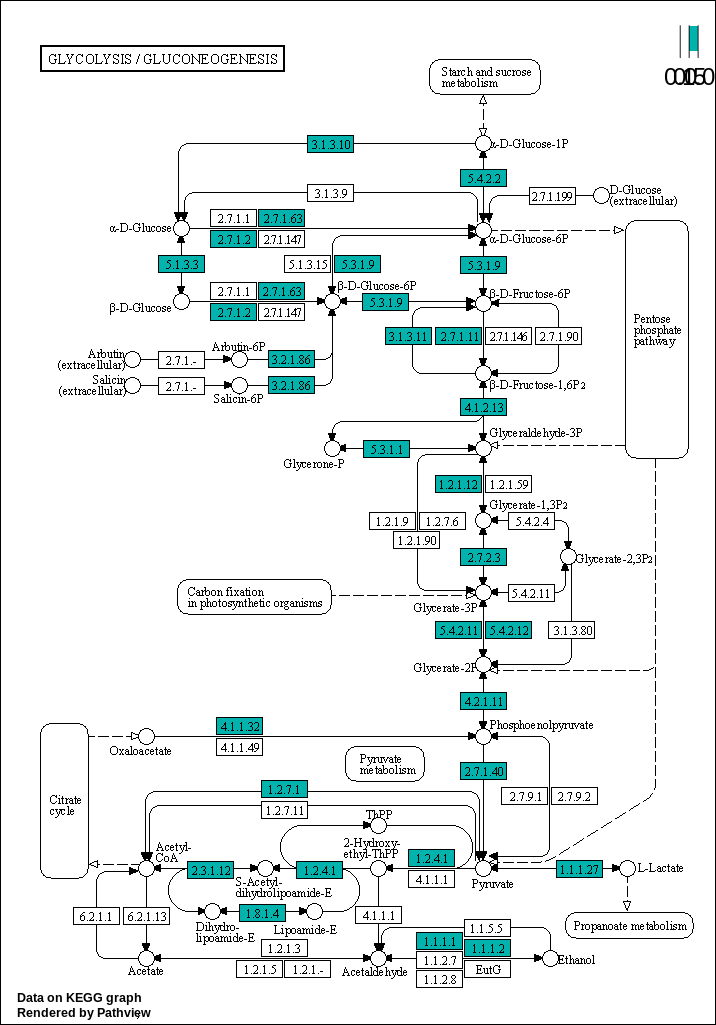

[1] "Citrate cycle (TCA cycle)"


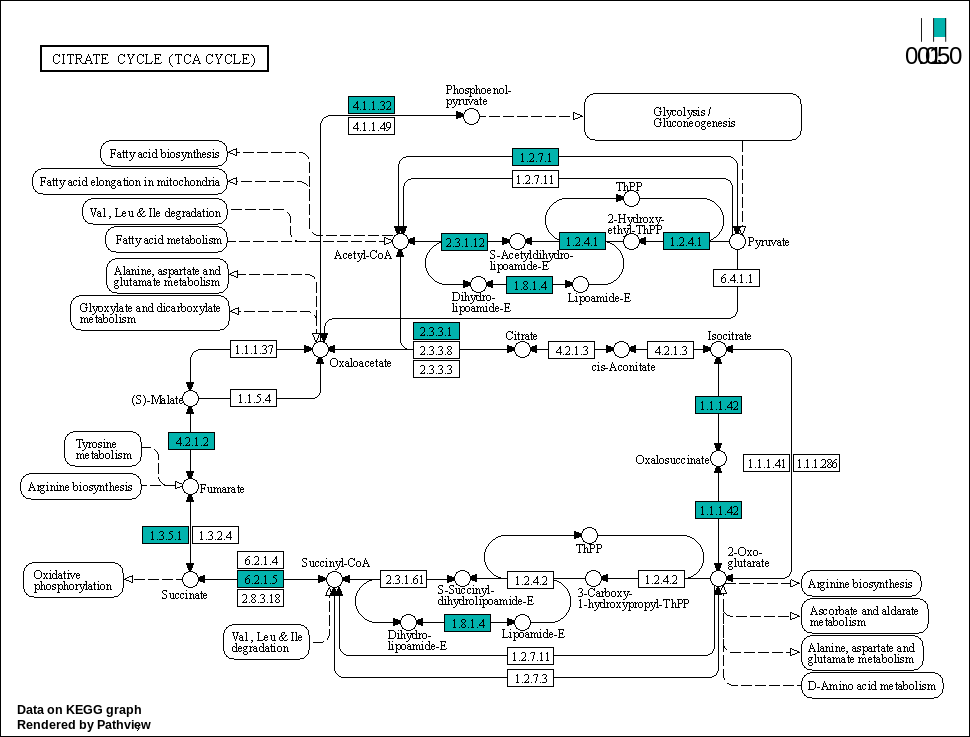

[1] "Pentose phosphate pathway"


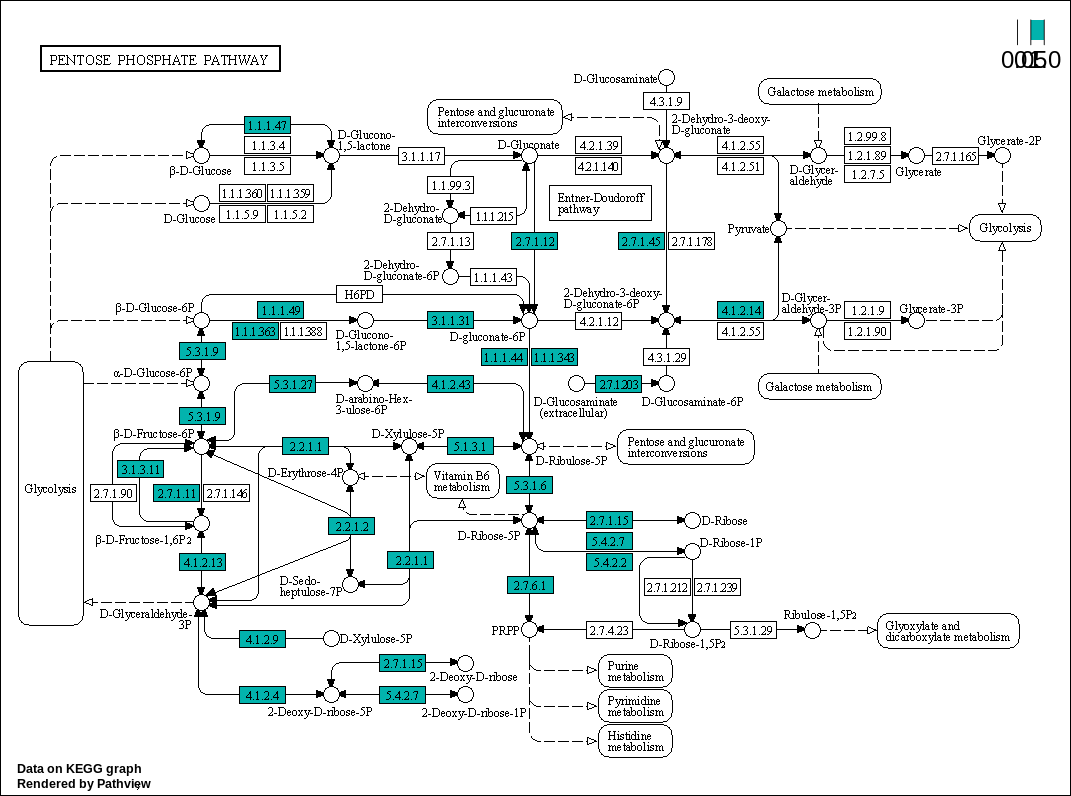

[1] "Fatty acid biosynthesis"


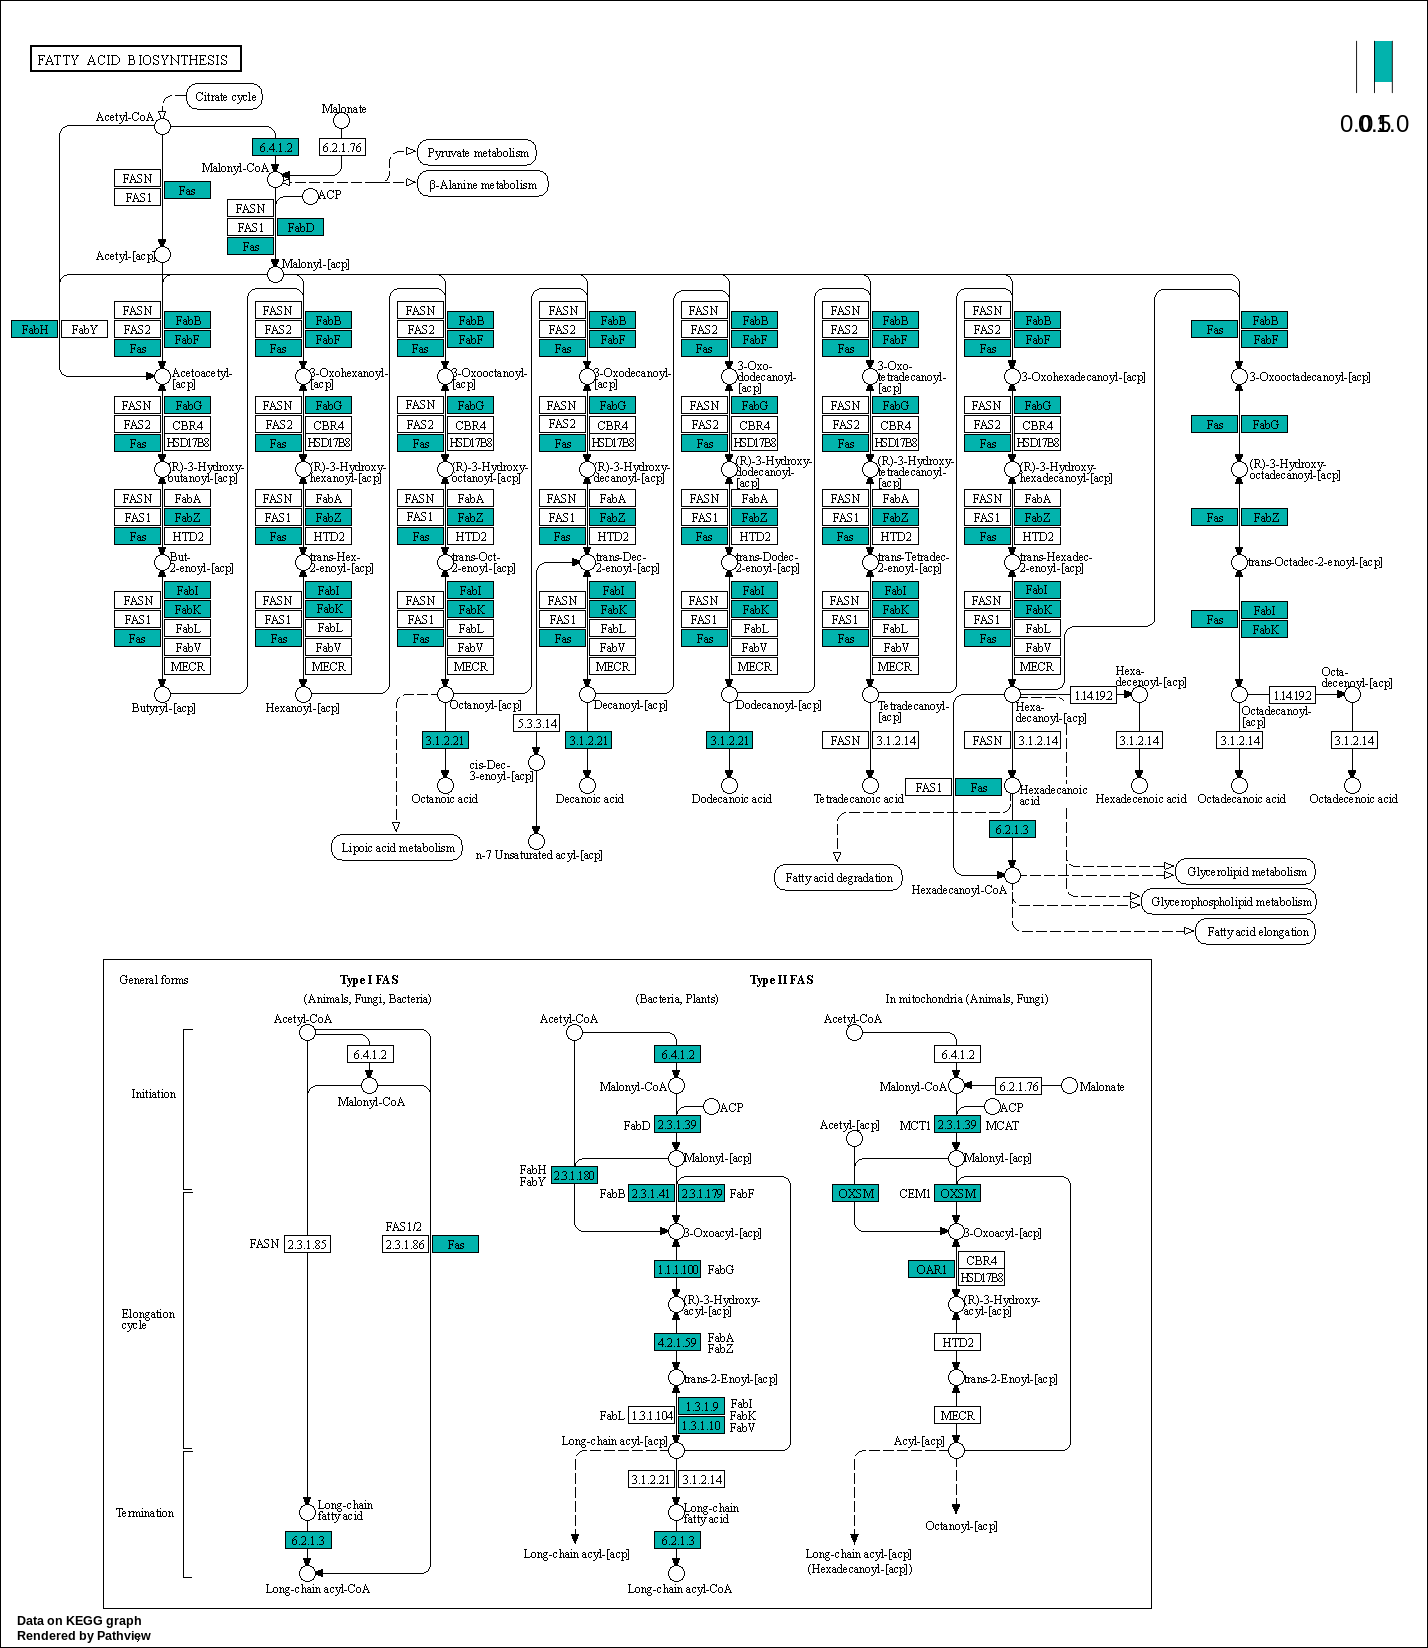

[1] "Oxidative phosphorylation"


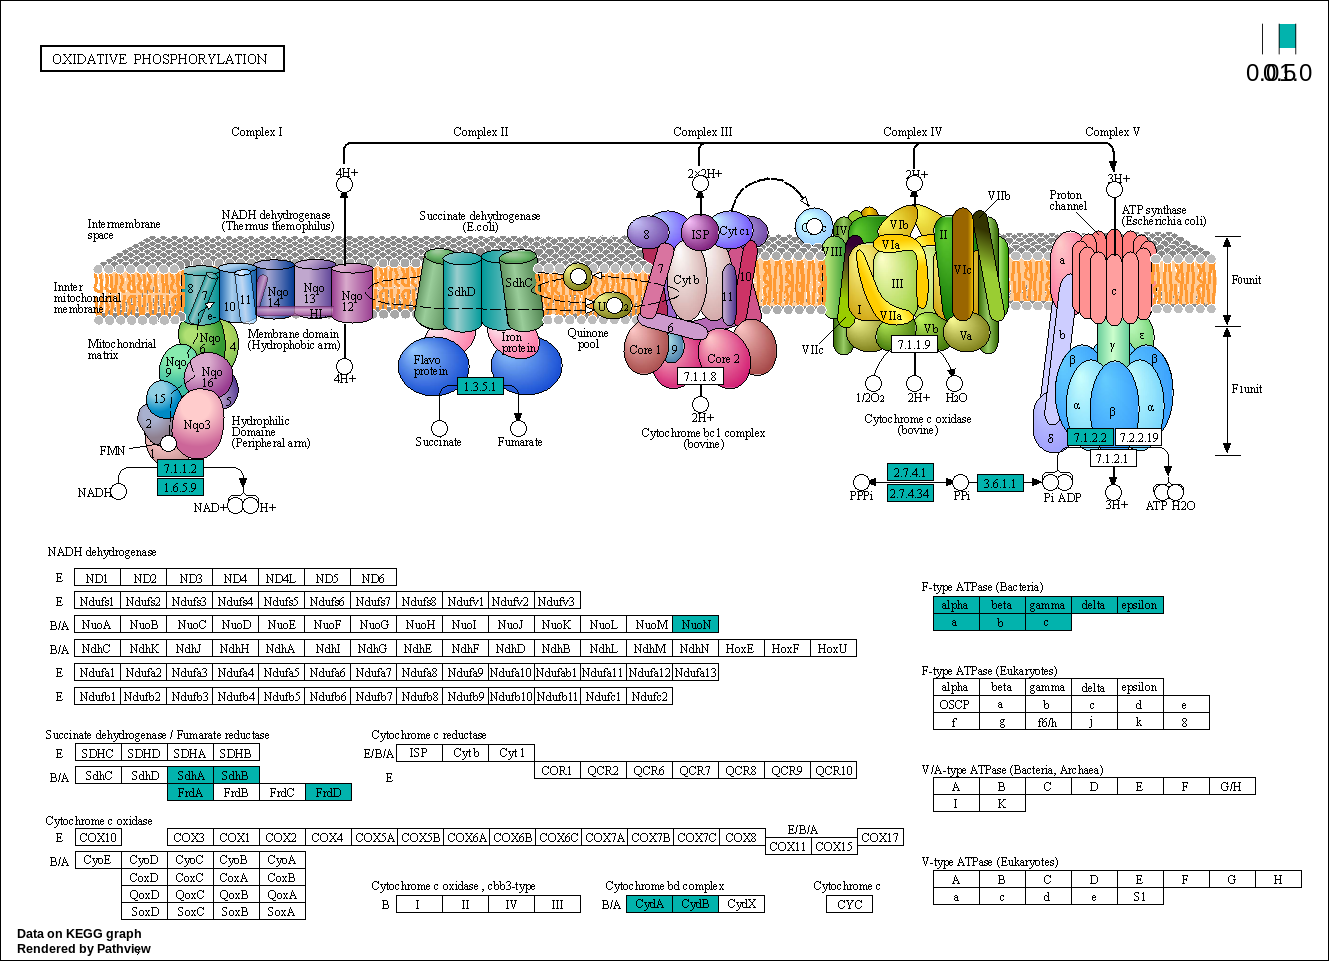

[1] "Pyrimidine metabolism"


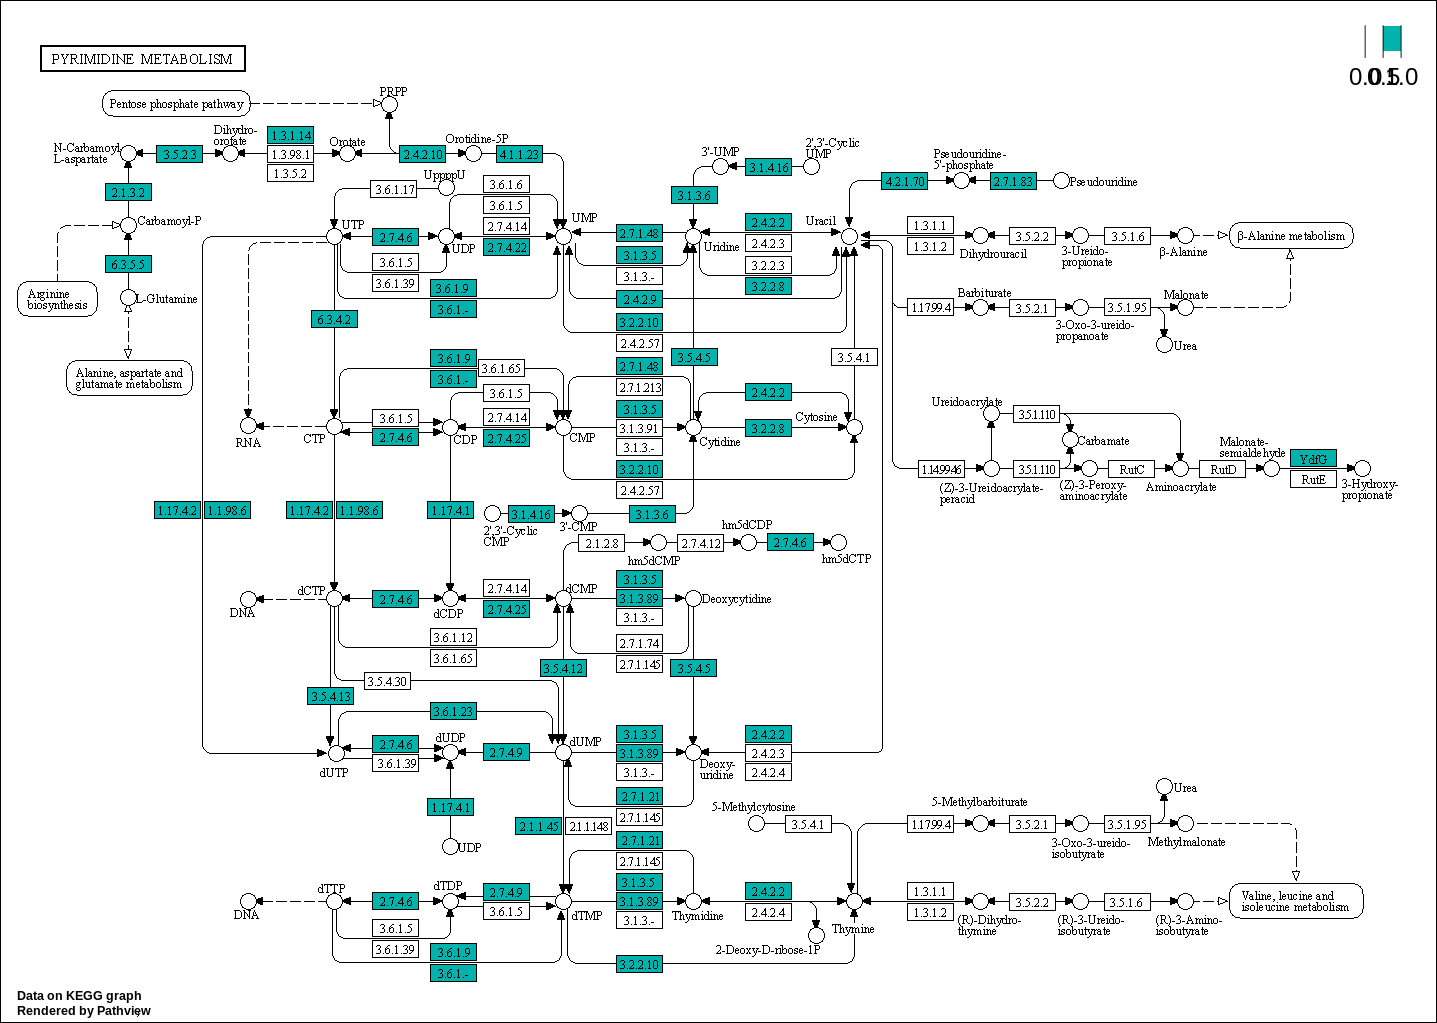

[1] "Taurine and hypotaurine metabolism"


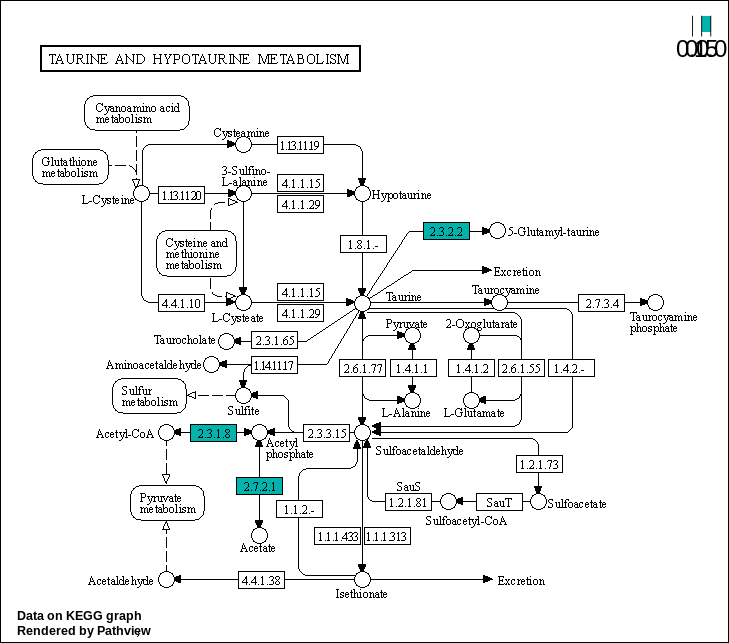

[1] "Glutathione metabolism"


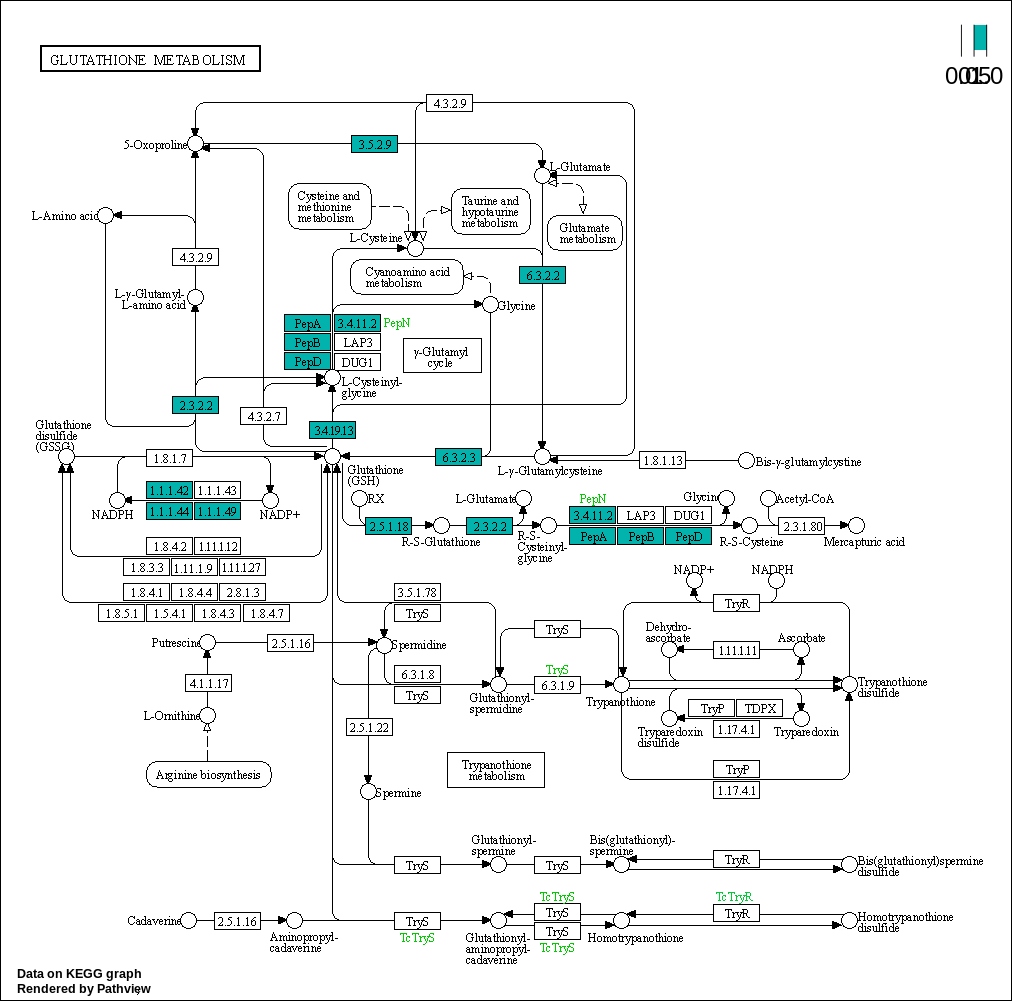

[1] "Streptomycin biosynthesis"


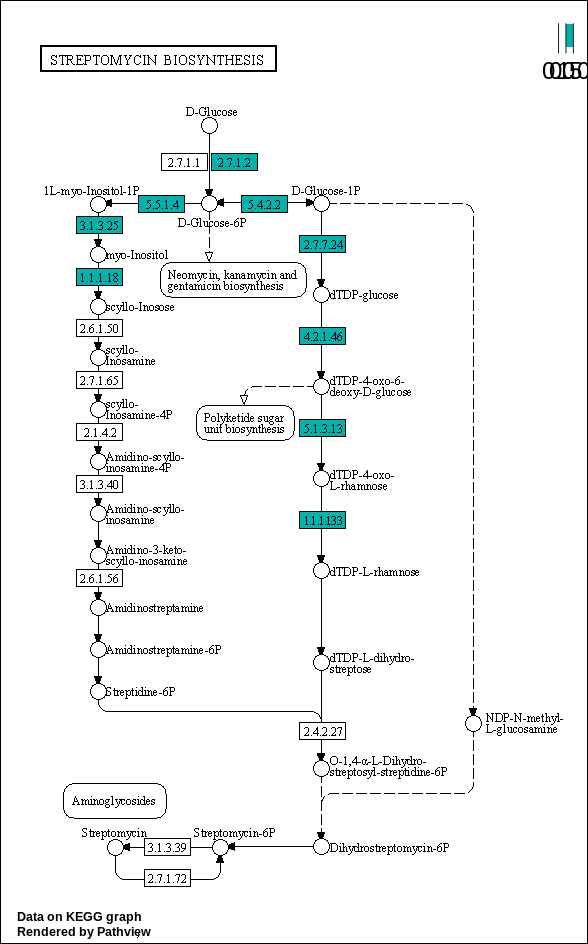

[1] "Nucleotide metabolism"


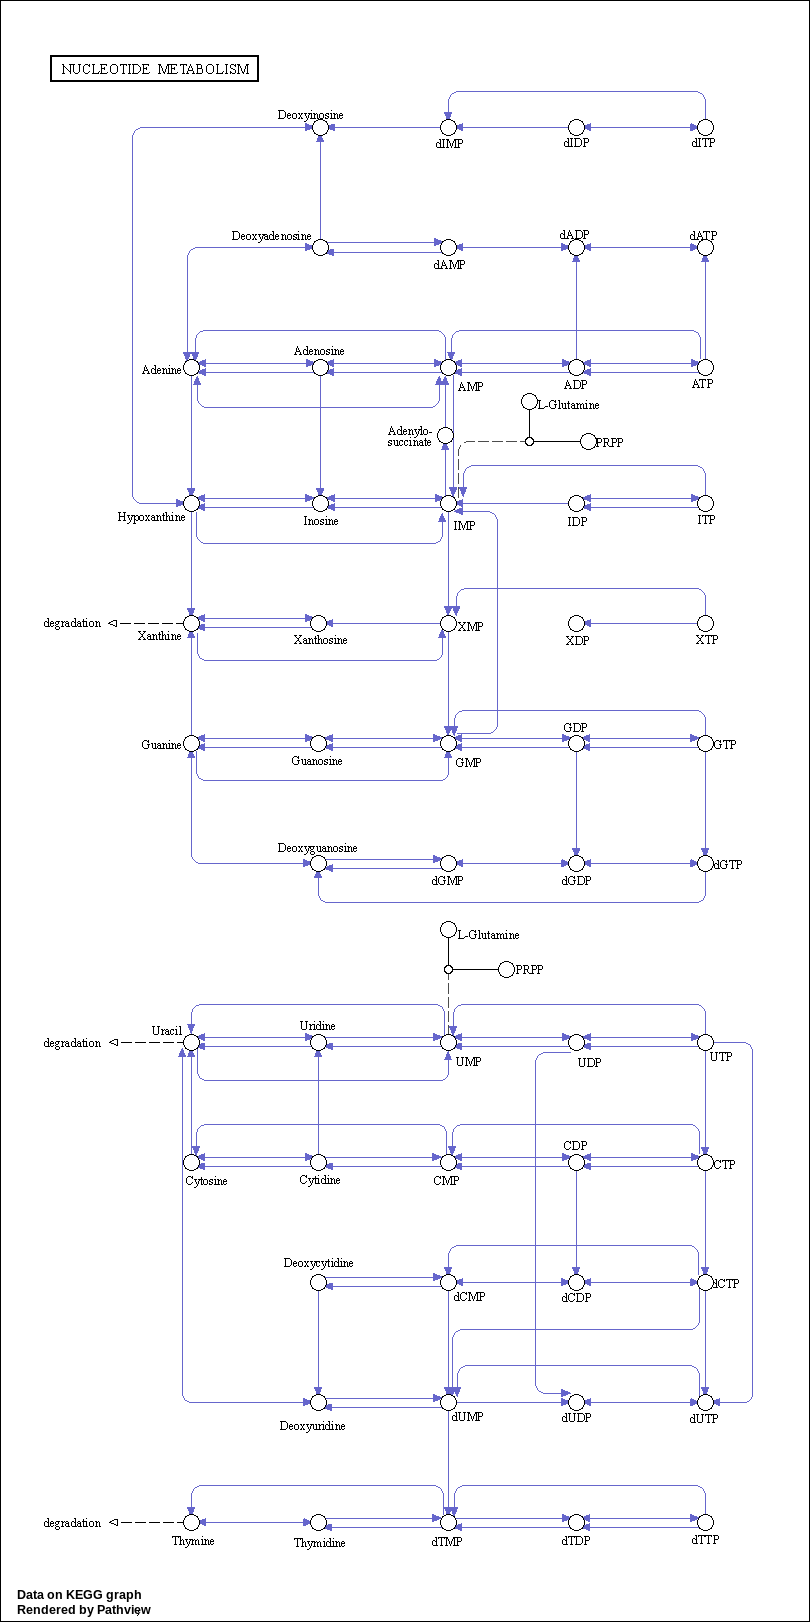

In [15]:
generatePathwayPlots()

---

## Resources and Documentation<a id='part2'/>
#### **Pathview Documentation**: 
- The official documentation for Pathview, a tool for pathway-based data integration and visualization. It provides an overview of the tool and explains how to use it effectively. 
- You can find more information at [https://pathview.uncc.edu/overview#kegg_view](https://pathview.uncc.edu/overview#kegg_view) .


#### **KEGGREST**
- KEGGREST is a Bioconductor package that provides programmatic access to the KEGG database. 
- More about KEGGREST at [http://www.bioconductor.org/packages/release/bioc/vignettes/KEGGREST/inst/doc/KEGGREST-vignette.html](http://www.bioconductor.org/packages/release/bioc/vignettes/KEGGREST/inst/doc/KEGGREST-vignette.html)